## Week 11 Homework (HW9)

### Q1: copulas

1. Use the example copula code below to provide posterior inference on the dependency structure between for **your own non normally distributed data that you find** ( SKIP THIS QUESTION )
2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html
3. Describe what a copula is and how the two verions of code implement it
4. Describe how to use this to create arbitrary multivariate GLM regressions

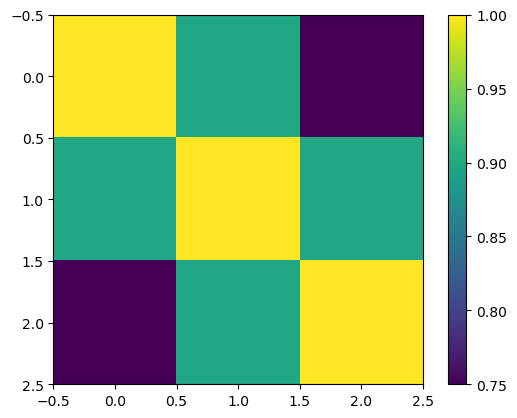

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

p = 3
#Psi = np.eye(p)
#a_cov = stats.invwishart(df=p+2, scale=Psi).rvs()
a_cor = (np.ones((p,p))*9+np.diag((1,1,1)))/10
a_cor[0,-1] -= 0.15
a_cor[-1,0] -= 0.15

n = 100
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)
plt.imshow(a_cor)
plt.colorbar();


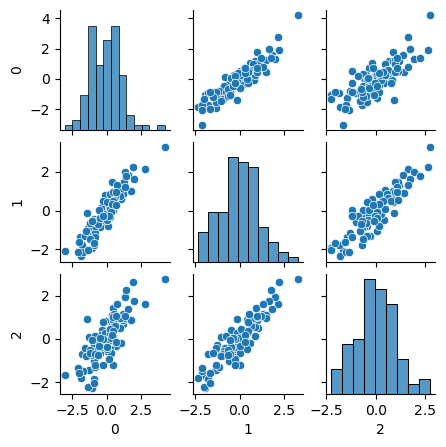

In [ ]:
import seaborn
import pandas as pd
seaborn.pairplot(pd.DataFrame(x),height=1.5);

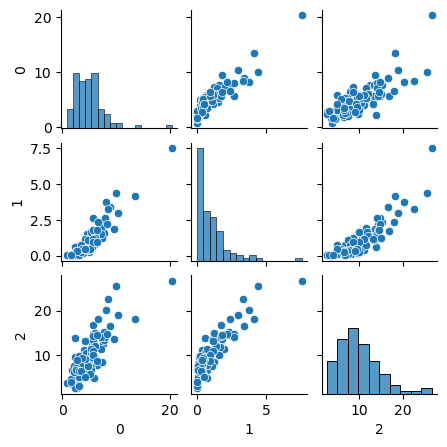

In [ ]:
y = x.copy()
y[:,0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:,0]))
y[:,1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:,1]))
y[:,2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:,2]))

seaborn.pairplot(pd.DataFrame(y),height=1.5);

In [ ]:
import pymc as pm
import arviz as az

with pm.Model() as copula:

    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=p0, beta=1, observed=y[:,0:1])
    y0_ = pm.Deterministic('y0_',
            pm.Normal.icdf(
               pm.math.exp(pm.Gamma.logcdf(y0, alpha=p0, inv_beta=1)),
                           mu=0, sigma=1))

    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=y[:,1:2])
    y1_ = pm.Deterministic('y1_',
            pm.Normal.icdf(
               pm.math.exp(pm.Exponential.logcdf(y1, mu=p1)),
                           mu=0, sigma=1))

    p2 = pm.HalfNormal('p2', sigma=10)
    y2 = pm.ChiSquared('y2', nu=p2, observed=y[:,2:3])
    y2_ = pm.Deterministic('y2_',
            pm.Normal.icdf(
               pm.math.exp(pm.ChiSquared.logcdf(y2, nu=p2)),
                           mu=0, sigma=1))

    L,R,stds = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=3),
                                 compute_corr=True)

    potential = pm.Potential("MVNeval",
                             pm.logp(pm.MvNormal.dist(mu=0, cov=R),
                             pm.math.concatenate([y0_,y1_,y2_], axis=1)))

    idata = pm.sample()
# This probally produces a lot of warnings but it will run and provide inference

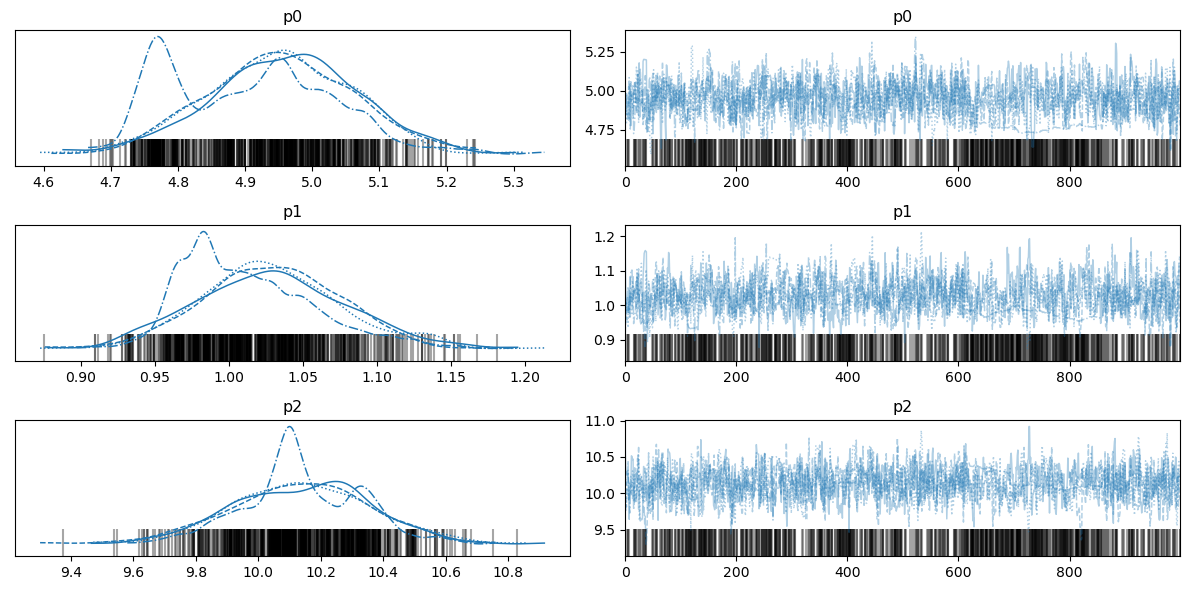

In [ ]:
# Estimation is essentially correct
az.plot_trace(idata, var_names=['p0','p1','p2'])
plt.tight_layout()

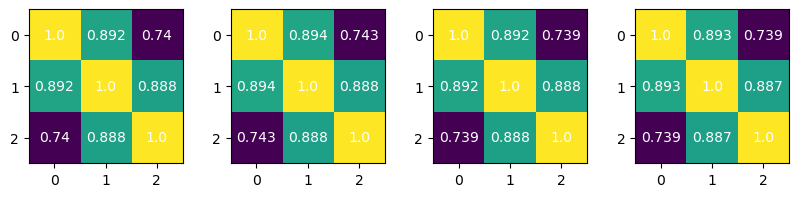

In [ ]:
# Estimation is essentially correct
fig,ax = plt.subplots(1,4,figsize=(10,2))
for i,c in enumerate(list(idata.posterior['R_corr'].values.mean(axis=1))):
    ax[i].imshow(c)
    for k in range(3):
        for j in range(3):
            ax[i].text(j,k,s=str(round(c[j,k],3)),
                       color='w', va='center', ha='center')

In [4]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

# =============================================================================
# synthetic data

np.random.seed(424)
n = 100  # number of observations
p = 3    # number of dimensions

# Create a target correlation matrix for the latent multivariate normal
corr = np.array([[1, 0.5, 0.3],
                 [0.5, 1, 0.2],
                 [0.3, 0.2, 1]])
# Cholesky decomposition to generate correlated normal data
L = np.linalg.cholesky(corr)
z_true = np.random.randn(n, p) @ L.T

# Transform each latent normal dimension into a different marginal:
# Dimension 0 -> Gamma; Dimension 1 -> Exponential; Dimension 2 -> Chi-square

# For Gamma, use the inverse CDF (ppf) of a Gamma distribution with shape=5.
y0 = stats.gamma(a=5).ppf(stats.norm.cdf(z_true[:, 0]))

# For Exponential, use the inverse CDF of an Exponential (scale=1).
y1 = stats.expon(scale=1).ppf(stats.norm.cdf(z_true[:, 1]))

# For Chi-square, use the inverse CDF of a Chi-square distribution with df=10.
y2 = stats.chi2(df=10).ppf(stats.norm.cdf(z_true[:, 2]))

# Combine into a single data array with shape (n, 3)
y = np.column_stack([y0, y1, y2])

In [6]:
# =============================================================================
# Fit Marginal Models Separately (Pass 1)
# =============================================================================

# --- Fit a Gamma model for y0 (first dimension) ---
with pm.Model() as gamma_model:
    # Priors for Gamma parameters: shape (alpha) and rate (beta)
    alpha = pm.HalfNormal('alpha', sigma=10)
    beta = pm.HalfNormal('beta', sigma=10)
    # Likelihood using the Gamma distribution
    y0_obs = pm.Gamma('y0_obs', alpha=alpha, beta=beta, observed=y[:, 0])
    gamma_trace = pm.sample(1000, tune=1000, target_accept=0.9, cores=1, progressbar=False)

# Extract posterior means for the Gamma parameters
alpha_mean = np.mean(gamma_trace.posterior['alpha'].values)
beta_mean = np.mean(gamma_trace.posterior['beta'].values)

# --- Fit an Exponential model for y1 (second dimension) ---
with pm.Model() as expo_model:
    # Prior for the Exponential rate parameter (lambda)
    lam = pm.HalfNormal('lam', sigma=10)
    # Likelihood using the Exponential distribution
    y1_obs = pm.Exponential('y1_obs', lam=lam, observed=y[:, 1])
    expo_trace = pm.sample(1000, tune=1000, target_accept=0.9, cores=1, progressbar=False)

# Extract the posterior mean for lambda
lam_mean = np.mean(expo_trace.posterior['lam'].values)

# --- Fit a Chi-square model for y2 (third dimension) ---
with pm.Model() as chisq_model:
    # Prior for degrees of freedom (nu) of the Chi-square distribution
    nu = pm.HalfNormal('nu', sigma=10)
    # Likelihood using the Chi-square distribution
    y2_obs = pm.ChiSquared('y2_obs', nu=nu, observed=y[:, 2])
    chisq_trace = pm.sample(1000, tune=1000, target_accept=0.9, cores=1, progressbar=False)

# Extract the posterior mean for nu
nu_mean = np.mean(chisq_trace.posterior['nu'].values)

# =============================================================================
# Transform Observed Data to Latent Normal Scale (Using Fitted Marginals)
# =============================================================================

# For each marginal, use the fitted CDF to convert observed data to uniform [0,1],
# then apply the inverse normal CDF (ppf) to get latent standard normal variables.

# Transform for Gamma (dimension 0)
u0 = stats.gamma.cdf(y[:, 0], a=alpha_mean, scale=1/beta_mean)
z0 = stats.norm.ppf(u0)

# Transform for Exponential (dimension 1)
u1 = stats.expon.cdf(y[:, 1], scale=1/lam_mean)
z1 = stats.norm.ppf(u1)

# Transform for Chi-square (dimension 2)
u2 = stats.chi2.cdf(y[:, 2], df=nu_mean)
z2 = stats.norm.ppf(u2)

# Combine the transformed latent variables into one array (n x 3)
z_data = np.column_stack([z0, z1, z2])


Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

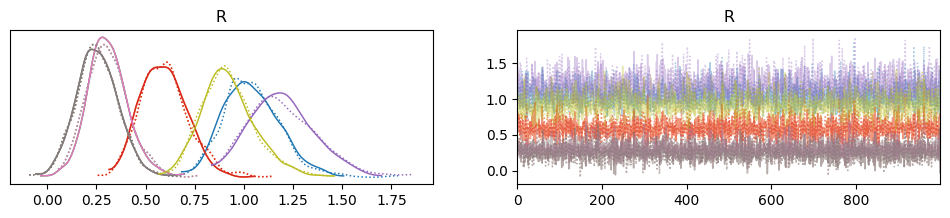

Estimated latent correlation matrix (posterior mean):
[[1.04050743 0.59546271 0.30742493]
 [0.59546271 1.19677099 0.25574992]
 [0.30742493 0.25574992 0.9217906 ]]


In [8]:
with pm.Model() as copula_model:
    # Latent mean
    mu = pm.Normal('mu', mu=0, sigma=1, shape=3)

    # LKJ Cholesky Covariance prior; note that we capture the correlation matrix in a Deterministic node
    chol, _, _ = pm.LKJCholeskyCov(
        'chol_cov',
        n=3,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0)
    )
    # Compute the full correlation matrix from the Cholesky factor:
    R = pm.Deterministic("R", pm.math.dot(chol, chol.T))

    # Likelihood: Multivariate Normal on the transformed data
    z_obs = pm.MvNormal('z_obs', mu=mu, chol=chol, observed=z_data)

    copula_trace = pm.sample(1000, tune=1000, target_accept=0.9, cores=1, progressbar=True)

# Plot the trace for the correlation matrix node "R"
az.plot_trace(copula_trace, var_names=['R'])
plt.show()

# Compute the posterior mean of the correlation matrix
corr_mean = np.mean(copula_trace.posterior['R'].values, axis=(0,1))
print("Estimated latent correlation matrix (posterior mean):")
print(corr_mean)


Q1.2: In this code we demonstrate a two-pass approach for copula estimation. In the first pass, we separately fit models to each marginal (Gamma for the first dimension, Exponential for the second, and Chi-square for the third) and extract point estimates of their parameters. Then, we transform the observed data into latent standard normal variables using these fitted marginal CDFs and the inverse normal CDF. In the second pass, we fit a multivariate normal model with an LKJ prior to recover the underlying correlation structure among the transformed data. This method is computationally efficient though it approximates the joint uncertainty compared to a fully integrated, single-model approach.

Q1.3: A copula model decouples the marginal distributions from the dependence structure of multivariate data. It does so by expressing the joint CDF as a combination of individual marginal CDFs, and a copula function that captures their correlation. In the fully joint (given) implementation, the model simultaneously estimates the marginal parameters and the unobserved (latent) correlation matrix. This joint approach is theoretically best because it fully propagates uncertainty across all parameters, so any uncertainty in the marginal distribution directly influences the estimation of the copula (dependencies). The two-pass approach estimates the marginal CDFs first and then fixes them to derive the unobserved correlations, which can potentially underestimate uncertainty in the correlation estimates. This is because once you fix marginal parameters from the first pass, their posterior uncertainty is not reflected in the second pass for correlation estimation (as we only use point estimates and not the full range).

Q1.4: To build arbitrary multivariate GLM regressions, using a copula framework, replace the marginal models with GLMs that incorporate their own regression and link functions that are tailored to the outcome's distribution. For example, take the fully joint model, which will then estimate the GLM parameters for each regression and the correlation structure together. This ensures that uncertainty in the regression coefficients and link functions is fully integrated into the joint posterior. This provides a complete propagation of uncertainty across both the individual GLMs and the dependence model. Alternatively, we can use the two-pass approach to estimate each GLM separately and then derive the unobserved correlations from the transformed data using our fixed estimates, but this does not fully reflect the uncertainty of the GLM parameters. Thus, the fully joint approach is theoretically more robust, as it more comprehensively accounts for previous parameter (multivariate GLM) uncertainty in the posterior.

### Q2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.



Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


True beta: [ 2.5  0.  -1.2  0.   1.   0. ]
Posterior mean of beta (spike-and-slab): [ 2.67128391e+00 -4.54069696e-05 -1.18304198e+00  0.00000000e+00
  1.01257097e+00 -4.14775620e-06]


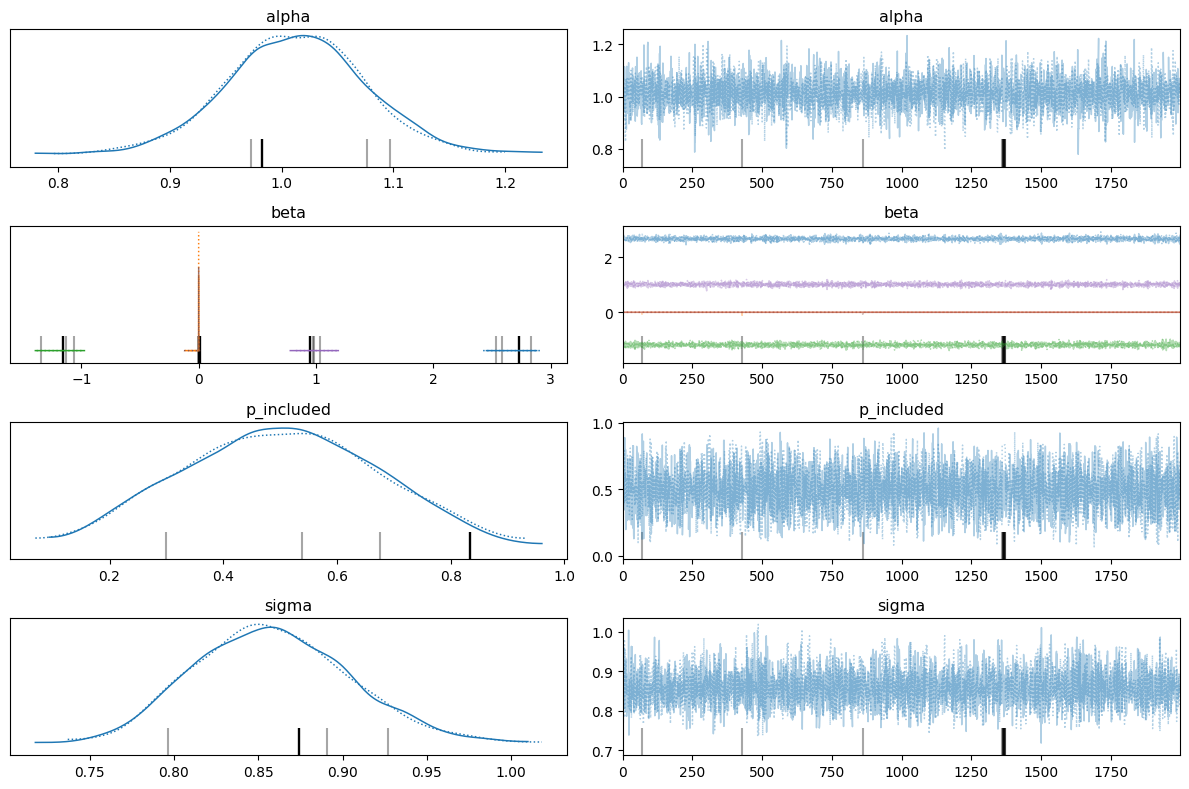

In [17]:
np.random.seed(424)
n = 200   # number of observations
p = 6     # number of predictors

# True coefficients: only predictors 0, 2, and 4 are nonzero
true_beta = np.array([2.5, 0.0, -1.2, 0.0, 1.0, 0.0])
true_alpha = 1.0

# Generate design matrix and outcome data
X = np.random.randn(n, p)
y = true_alpha + X.dot(true_beta) + np.random.normal(0, 1, size=n)

# ------------------------------
with pm.Model() as spike_slab_model:
    # probability for all coefficients
    p_included = pm.Beta('p_included', alpha=1, beta=1)

    # Bernoulli indicators for each coefficient
    spike = pm.Bernoulli('spike', p=p_included, shape=p)

    # Slab prior
    slab = pm.Normal('slab', mu=0, sigma=100, shape=p)

    # Combine via multiplication
    beta = pm.Deterministic('beta', spike * slab)

    # Intercept and noise
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    sigma = pm.Exponential('sigma', 1.0)

    # Linear regression likelihood
    mu = alpha + pm.math.dot(X, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # Sample with moderately high target_accept
    trace = pm.sample(2000, tune=4000, target_accept=0.98, random_seed=424)

# ------------------------------
# Diagnostics and Results
# ------------------------------
az.plot_trace(trace, var_names=["alpha", "beta", "p_included", "sigma"]);
plt.tight_layout()

print("True beta:", true_beta)
print("Posterior mean of beta (spike-and-slab):",
      np.mean(trace.posterior['beta'].values, axis=(0,1)))


Output()

True beta: [ 2.5  0.  -1.2  0.   1.   0. ]
Posterior mean of beta (L2): [ 2.66938770e+00 -1.01907356e-03 -1.18144714e+00  2.04543310e-02
  1.00579452e+00  4.30708169e-02]


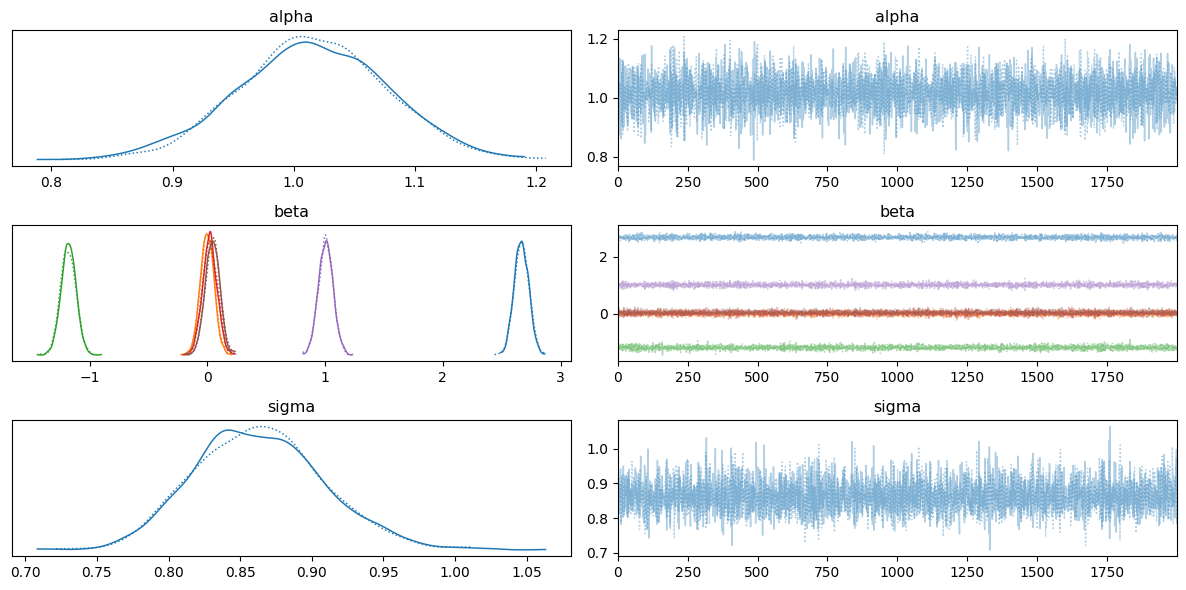

In [15]:
# Diffuse Normal (L2) Model
# ------------------------------
with pm.Model() as l2_model:
    # Diffuse Normal priors for intercept and all coefficients
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta = pm.Normal("beta", mu=0, sigma=5, shape=p)
    sigma = pm.Exponential("sigma", 1.0)

    # Linear regression likelihood
    mu_val = alpha + pm.math.dot(X, beta)
    y_obs = pm.Normal("y_obs", mu=mu_val, sigma=sigma, observed=y)

    # Sample from the posterior
    l2_trace = pm.sample(2000, tune=1000, target_accept=0.9)

# ------------------------------
# Diagnostics and Results
# ------------------------------
az.plot_trace(l2_trace, var_names=["alpha", "beta", "sigma"]);
plt.tight_layout()

print("True beta:", true_beta)
print("Posterior mean of beta (L2):",
      np.mean(l2_trace.posterior['beta'].values, axis=(0,1)))

From the plots and output, we can see that the spike-and-slab approach tends to push irrelevant predictors (betas) closer to zero in its posterior. In the trace plots for the spike-and-slab betas, coefficients corresponding to “true zeros” cluster near zero, but the truly nonzero coefficients remain noticeably away from zero, reflecting the model's belief that those predictors are important. The L2 (diffuse normal) model shrinks all coefficients, but so they are still distributed around 0 (not exactly 0). This difference is especially apparent if you compare the posterior means or medians for each method: spike-and-slab can effectively “turn off” some predictors (setting to 0 or something e-05 or e-06), whereas L2 keeps them in the model with a more modest shrinkage (e-02 or e-03).

In terms of the overall fit, both methods find the coefficients fairly accurately. The spike-and-slab model can be more interpretable when you want discrete statements about which predictors are included or excluded. However, it can be more challenging to sample from, as evidenced by occasional divergences (which requires reduction via more tuning/higher target_accept). The L2 approach, on the other hand, is often more stable to sample and simpler to implement but does not provide the same explicit variable selection chance.


I used a limited dataset to reduce computational demands. With more data (n) or predictors (p), the runtime and memory usage of both approaches increase. Spike and slab will have additional Bernoulli indicators can enlarge the parameter space, making sampling slower and more prone to divergences. As well, more outcome variables (m) for a multivariate regression, you further complicate the likelihood and inflate the parameter count. This relates to the idea of Bayes' Occam Razor, which is that Bayesian methods will tend to prefer simpler models. In real-world scenarios with large datasets and many predictors, you might need advanced methods or higher statistical power for optimal prediction performance out-of-sample, which is generally the most important thing for a model.

### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



### The Horseshoe prior

The [PyMC overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html) and [many](https://www.google.com/search?q=pymc+horseshoe&oq=pymc+horseshoe) other [resources](https://mellorjc.github.io/HorseshoePriorswithpymc3.html) provide ***Horseshoe prior*** [[1]](https://www.jstor.org/stable/25734098) [[2]](https://faculty.mccombs.utexas.edu/carlos.carvalho/Carvalhoetal2009.pdf) implementations

| Half-Cauchy $\text{HC}_+(\xi)$ | Horseshoe Prior $\text{HSP}$ | Shrinkage $\kappa$ | Change of Variables|
|:-:|:-:|:-:|:-:|
|$$f(x \mid \xi) = \frac{2\cdot 1_{[x>=0]}(x)}{\pi \xi \left[1 + \left(\frac{x}{\xi}\right)^2\right]}$$|\begin{align*}w_i|\tau &\sim N(0, \sigma^{2}=\lambda_i^2\tau^2)\\\lambda_i &\sim HC_+(1)\\\tau &\sim HC_+(\tau_0)\end{align*}|\begin{align*}\kappa_{\lambda_i} ={}& 1/(1+\lambda_i^2)\\\lambda_i ={}& \sqrt{1/\kappa_{\lambda_i}-1}\\J_{\kappa_{\lambda_i}} ={}& \frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2} \end{align*}|\begin{align*}f(\kappa_{\lambda_i}) = {} & f\left(\lambda_i = \sqrt{1/\kappa_{\lambda_i}-1}\right)\\ {} & \times \underbrace{\frac{1}{2}(\kappa_{\lambda_i}^{-1}-1)^{-\frac{1}{2}}\times \kappa_{\lambda_i}^{-2}}_{J_{\kappa_{\lambda_i}}} \end{align*}|



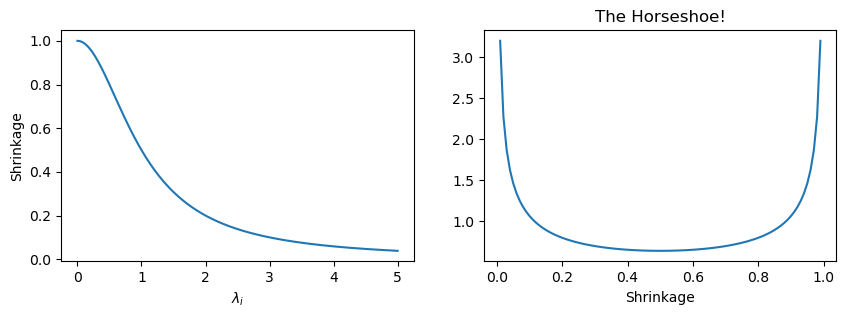

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
support = np.linspace(0,5,1000)
# shrnk = trans(spprt) = 1/(1+sprt**2)
shrinkage = 1/(1+support**2)
ax[0].plot(support, shrinkage)
ax[0].set_ylabel("Shrinkage")
ax[0].set_xlabel("$\\lambda_i$")
# change of variables:
# spprt = (1/shrnk-1)**0.5; E.g., 1/(1+.5**2), (1/.8-1)**0.5;
# jacobian: .5(1/shrnk-1)**(-.5)*shrnk**(-2)
shrinkage = np.linspace(0.01,.99,99)
ax[1].plot(shrinkage,
           stats.halfcauchy(scale=1).pdf((1/shrinkage-1)**0.5) *
           .5*(1/shrinkage-1)**(-.5)*shrinkage**(-2))
ax[1].set_title('The Horseshoe!')
ax[1].set_xlabel("Shrinkage");

Output()

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
ERROR:pymc.stats.convergence:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.11/dist-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


True beta: [ 2.5  0.  -1.2  0.   1.   0. ]
Posterior mean of beta (spike-and-slab): [ 2.67128391e+00 -4.54069696e-05 -1.18304198e+00  0.00000000e+00
  1.01257097e+00 -4.14775620e-06]


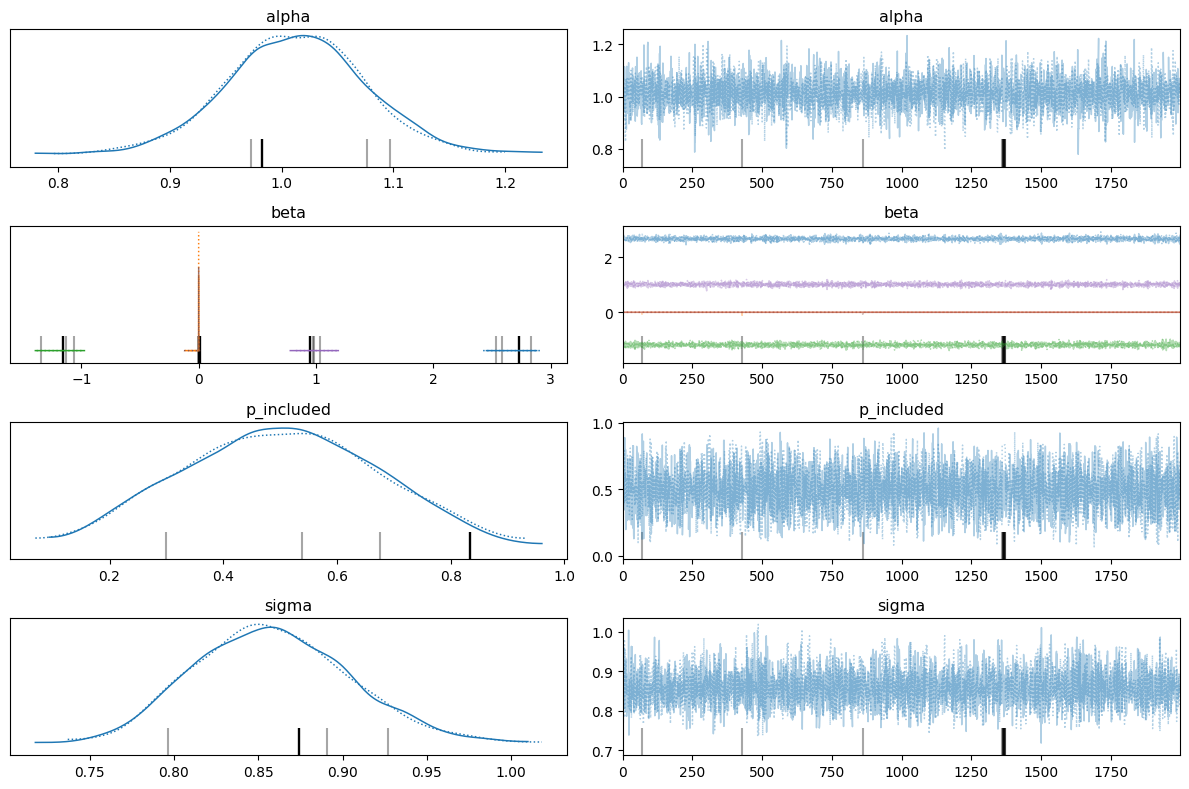

In [18]:
# Q3: data same as before
# ------------------------------
np.random.seed(424)
n = 200
p = 6

# True coefficients: only predictors 0, 2, and 4 are nonzero
true_beta = np.array([2.5, 0.0, -1.2, 0.0, 1.0, 0.0])
true_alpha = 1.0

# Generate design matrix and outcome data
X = np.random.randn(n, p)
y = true_alpha + X.dot(true_beta) + np.random.normal(0, 1, size=n)

# spike and slab same as before
# ------------------------------
# ------------------------------
with pm.Model() as spike_slab_model:
    # probability for all coefficients
    p_included = pm.Beta('p_included', alpha=1, beta=1)

    # Bernoulli indicators for each coefficient
    spike = pm.Bernoulli('spike', p=p_included, shape=p)

    # Slab prior
    slab = pm.Normal('slab', mu=0, sigma=100, shape=p)

    # Combine via multiplication
    beta = pm.Deterministic('beta', spike * slab)

    # Intercept and noise
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    sigma = pm.Exponential('sigma', 1.0)

    # Linear regression likelihood
    mu = alpha + pm.math.dot(X, beta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # Sample with moderately high target_accept
    trace = pm.sample(2000, tune=4000, target_accept=0.98, random_seed=424)

# ------------------------------
# Diagnostics and Results
# ------------------------------
az.plot_trace(trace, var_names=["alpha", "beta", "p_included", "sigma"]);
plt.tight_layout()

print("True beta:", true_beta)
print("Posterior mean of beta (spike-and-slab):",
      np.mean(trace.posterior['beta'].values, axis=(0,1)))


Output()

ERROR:pymc.stats.convergence:There were 165 divergences after tuning. Increase `target_accept` or reparameterize.


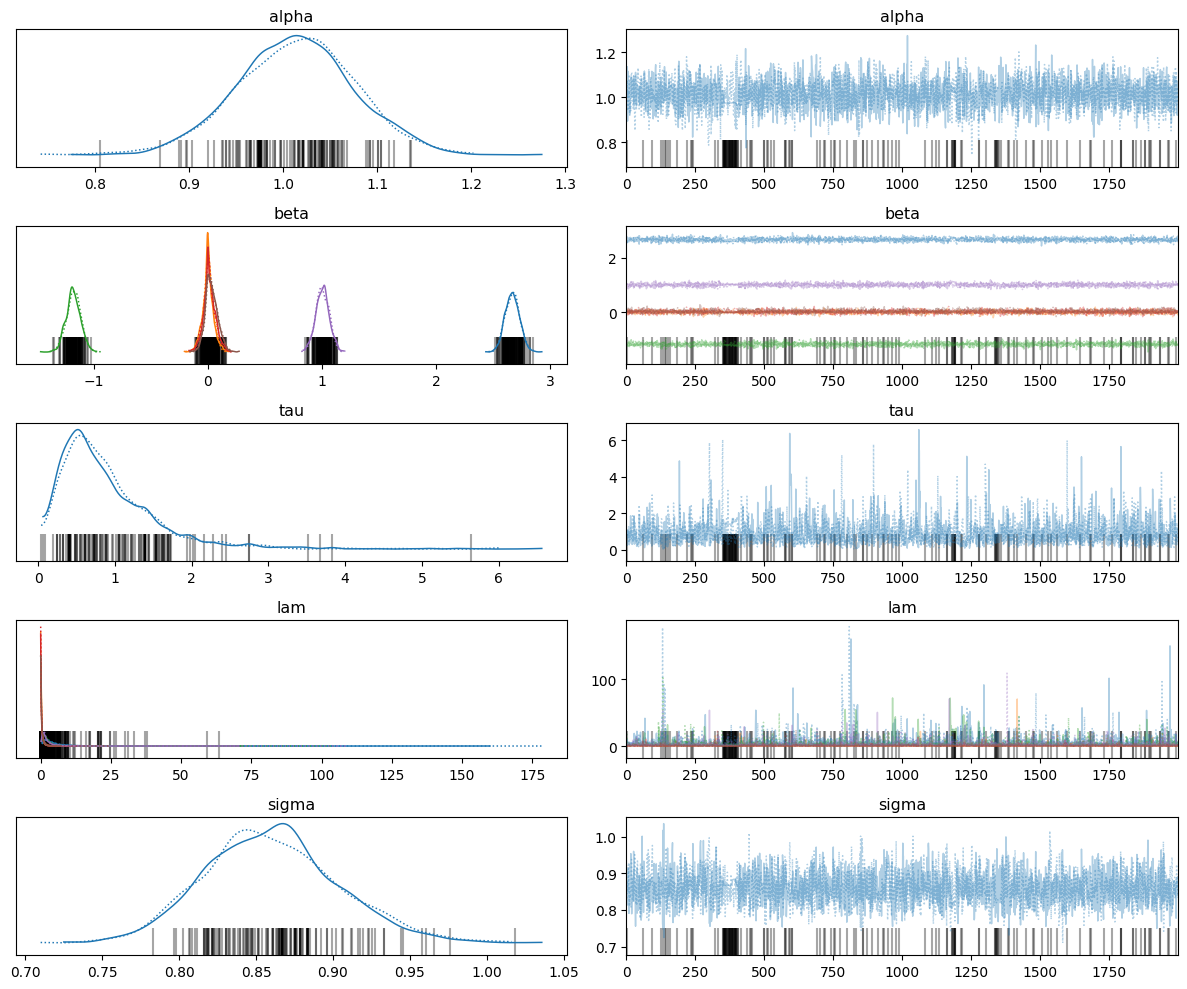

True beta: [ 2.5  0.  -1.2  0.   1.   0. ]
Posterior mean of beta (Horseshoe): [ 2.66681175e+00  1.67146805e-03 -1.17865227e+00  1.23969611e-02
  1.00368840e+00  3.17418671e-02]


In [21]:
# Horseshoe
with pm.Model() as horseshoe_model:
    # Global scale
    tau_0 = 1.5  # can tweak this hyperparameter. the smaller the tau, the more shrinkage towards 0.
    tau = pm.HalfCauchy("tau", beta=tau_0)

    # Local scales
    lam = pm.HalfCauchy("lam", beta=1.0, shape=p)

    # Horseshoe prior for coefficients
    beta = pm.Normal("beta", mu=0, sigma=tau * lam, shape=p)

    # Intercept
    alpha = pm.Normal("alpha", mu=0, sigma=5)

    # Noise term
    sigma = pm.Exponential("sigma", 1.0)

    # Linear regression likelihood
    mu = alpha + pm.math.dot(X, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # Sample from the posterior
    horseshoe_trace = pm.sample(2000, tune=4000, target_accept=0.9)

# Diagnostics
az.plot_trace(horseshoe_trace, var_names=["alpha", "beta", "tau", "lam", "sigma"]);
plt.tight_layout()
plt.show()

print("True beta:", true_beta)
print("Posterior mean of beta (Horseshoe):",
      np.mean(horseshoe_trace.posterior["beta"].values, axis=(0,1)))


From the trace plots of the horseshoe model, similar to the spike-and-slab model, most irrelevant coefficients are strongly shrunken toward zero, while the relevant ones remain noticeably away from zero. Unlike the spike-and-slab model, which uses discrete indicators to “switch off” predictors, the horseshoe exerts a continuous shrinkage effect. This gives local scale parameters (lambdas) that are very small for predictors the data believes are close to 0, leading to near-zero posterior means for those betas. Meanwhile, the relevant predictors retain larger values, indicating less shrinkage, so their coefficients remain closer to the true values. Different from spike-and-slab, there is a global scale parameter τ which influences how aggressively all coefficients are shrunk overall, but the local lambda factors let the important predictors “escape” from the tau regularization.

The horseshoe approach also avoids the discrete jumps created by Bernoulli indicators of the spike-and-slab, heavily suppressing predictors that appear unimportant and giving them with tiny (but nonzero) posterior means. This is preferable when we want continuous shrinkage or expect only a small subset of large signals. Spike-and-slab may provide clearer distinctions, but can be more prone to divergences (as discussed in Q2). In practice, both methods can recover the truly nonzero predictors quite well with similar results (based on the output), with spike-and-slab giving you discrete variable selection (0ing out means or setting them to near 0 values (e-06 and e-05)) and horseshoe offering a smoother, fully continuous way (setting near-zero means to e-02 and e-03 values) to identify and shrink irrelevant predictors.